In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import scipy
import ipynb.fs
import pandas as pd

from ipynb.fs.defs.BCI_COMP_IV_functions import (extractInfo, featureExtraction, createFilterBank,
                                                testWindowLength, testClassifier, testFrequencyBand,
                                                testWindowStartTime,testWindowStartTime_Length, startRunningClassifier,
                                                tuneModelHyperParams)


In [2]:
dataB = scipy.io.loadmat("BCICIV_1_mat/BCICIV_calib_ds1b.mat")

dataB["cnt"] = 0.1 * dataB["cnt"].astype(float)

eeg = dataB["cnt"].T 
nChannels, nSamples = eeg.shape

motionIntentComp, idleStateComp = [0,-1], [0,-1]

calibDataStore, testData_motionIntent, _ = featureExtraction(dataB,0.7,motionIntentComp, idleStateComp)

calibData_idle_motionIntent, testData_idle_motionIntent, W_idle_motionIntent = featureExtraction(dataB,0.7,motionIntentComp, idleStateComp,ExtractionType="idle_motionIntent")



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Base Classifiers for detecting Idle State (no resampling)

There is no need to resample because there will always be as many idle states as there are motion intent states

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import roc_curve, auc, accuracy_score


ldaModel = LDA()
SVMmodel = SVC(probability=True,class_weight="balanced") 
logRegModel = LogisticRegression(class_weight="balanced")


In [4]:
nCols = len(calibData_idle_motionIntent.columns)

print("Cross Validation Score")
print("-----------------------")
print("LDA: ",np.mean(cross_val_score(ldaModel,calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1],cv=5)))
print("Logistic Regression: ",np.mean(cross_val_score(logRegModel,calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1],cv=5)))
print("SVM: ",np.mean(cross_val_score(SVMmodel,calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1],cv=5)))
print()


Cross Validation Score
-----------------------
LDA:  0.8642857142857142
Logistic Regression:  0.85
SVM:  0.85



### Tuning Classifiers for detecting Idle State (no resampling)

In the context of predicting between an idle state and a motion intent state, the cost of misclassifying idle state is higher than the cost of misclassifying motion intent state, therefore accuracy alone may not be enough to evaluate the performance of the classifier. Instead, I may need to use a metric that takes into account the false positives and false negatives. The F1 score is a good choice in this case because it balances precision and recall, and provides a single score that reflects the overall performance of the classifier.

In [5]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [6]:
bestMods = tuneModelHyperParams(calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1],testData_idle_motionIntent.iloc[:,:nCols-1], testData_idle_motionIntent.iloc[:,nCols-1])


In [7]:
bestMods

defaultdict(dict,
            {'accuracy': {'SVC': (SVC(C=1000, class_weight='balanced', gamma=0.1, probability=True),
               0.8833333333333333),
              'LogReg': (LogisticRegression(C=0.3727593720314938, class_weight='balanced',
                                  solver='liblinear'),
               0.8583333333333333),
              'LDA': (LinearDiscriminantAnalysis(shrinkage=0.0, solver='lsqr'),
               0.85)},
             'roc_auc': {'SVC': (SVC(C=10, class_weight='balanced', gamma=0.1, probability=True),
               0.875),
              'LogReg': (LogisticRegression(C=0.004094915062380427, solver='liblinear'),
               0.775),
              'LDA': (LinearDiscriminantAnalysis(shrinkage=0.4, solver='lsqr'),
               0.8416666666666667)},
             'f1': {'SVC': (SVC(C=0.01, class_weight='balanced', gamma=1, kernel='linear', probability=True),
               0.8333333333333334),
              'LogReg': (LogisticRegression(C=0.3727593720314938

In [8]:
bestModel, bestPerformance = None, 0

for metric in bestMods:
    for model in bestMods[metric]:
        mod, perf = bestMods[metric][model]

        if perf > bestPerformance:
            bestModel, bestPerformance = mod, perf


In [9]:
print(bestModel, bestPerformance)

SVC(C=1000, class_weight='balanced', gamma=0.1, probability=True) 0.8833333333333333


In [10]:
idlesStateClassifier = bestModel

In [11]:
idlesStateClassifier

SVC(C=1000, class_weight='balanced', gamma=0.1, probability=True)

### Base Classifier for classifying motion intent signals

In [12]:
import sklearn
from sklearn.calibration import CalibratedClassifierCV

ldaModel = LDA()
SVMmodel = SVC(probability=True)
logRegModel = LogisticRegression()


In [13]:
for name, calibData in calibDataStore.items():

    nCols = len(calibData.columns)
    print(name,end="\n")
    print("-----------")

    print("LDA: ",np.mean(cross_val_score(ldaModel,calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1],cv=5)))
    print("Logistic Regression: ",np.mean(cross_val_score(logRegModel,calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1],cv=5)))
    print("SVM: ",np.mean(cross_val_score(SVMmodel,calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1],cv=5)))
    print()


RO
-----------
LDA:  0.789655172413793
Logistic Regression:  0.7825123152709359
SVM:  0.7830049261083744

SMOTE
-----------
LDA:  0.7967980295566501
Logistic Regression:  0.789655172413793
SVM:  0.7830049261083742

RU
-----------
LDA:  0.7902116402116401
Logistic Regression:  0.7976190476190476
SVM:  0.8121693121693122

CC
-----------
LDA:  0.7828042328042327
Logistic Regression:  0.7904761904761904
SVM:  0.7981481481481482

None
-----------
LDA:  0.7928571428571429
Logistic Regression:  0.7714285714285714
SVM:  0.7714285714285715



### Tuned Classification

In the context of distinguishing between left hand motor imagery signals and right hand motor imagery signals, using AUC-ROC as a metric may be more appropriate than F1 score if the classes are imbalanced. AUC-ROC takes into account the true positive rate (sensitivity) and false positive rate (1-specificity) of the model across a range of classification thresholds, which makes it robust to class imbalance.

F1 score, on the other hand, is based on precision and recall and may be affected by class imbalance. If one class is much smaller than the other, the F1 score may be biased towards the larger class.

Therefore, AUC-ROC would be a good choice in this case to evaluate the model's ability to discriminate between the two classes, regardless of class imbalance.

In [15]:
for name, calibData in calibDataStore.items():
    
    bestMods = tuneModelHyperParams(calibData.iloc[:,:nCols-1],
                                    calibData.iloc[:,nCols-1],
                                    testData_motionIntent.iloc[:,:nCols-1],
                                    testData_motionIntent.iloc[:,nCols-1])
    
    bestModel, bestPerformance = None, 0

    for metric in bestMods:
        for model in bestMods[metric]:
            mod, perf = bestMods[metric][model]

            if perf > bestPerformance:
                bestMetric, bestModel, bestPerformance = metric, mod, perf

    print(name)
    print("-------")
    print(f"Model = {bestModel}, Performance = {bestPerformance}, Metric = {bestMetric} ")
    print()
    print(f"All metrics = {bestMods}")
    print()


RO
-------
Model = LogisticRegression(C=0.0017575106248547913, class_weight='balanced',
                   solver='liblinear'), Performance = 0.9, Metric = f1 

All metrics = defaultdict(<class 'dict'>, {'accuracy': {'SVC': (SVC(C=100, class_weight='balanced', gamma=0.001, probability=True), 0.85), 'LogReg': (LogisticRegression(C=0.001, class_weight='balanced', solver='newton-cg'), 0.85), 'LDA': (LinearDiscriminantAnalysis(shrinkage=0.8, solver='lsqr'), 0.85)}, 'roc_auc': {'SVC': (SVC(C=1, class_weight='balanced', gamma=1, probability=True), 0.85), 'LogReg': (LogisticRegression(C=0.21209508879201905, class_weight='balanced', penalty='l1',
                   solver='liblinear'), 0.8666666666666667), 'LDA': (LinearDiscriminantAnalysis(shrinkage=0.6000000000000001, solver='lsqr'), 0.8666666666666667)}, 'f1': {'SVC': (SVC(C=100, class_weight='balanced', gamma=0.001, probability=True), 0.85), 'LogReg': (LogisticRegression(C=0.0017575106248547913, class_weight='balanced',
                   

### Window Start time test

### Accuracy

In [16]:
# bestEstimator_start_time, W_start_time = testWindowStartTime(dataB,
#                                                              0.7,
#                                                              4)


### Investigating the effect of varying the frquency band (for each resampling technique)

In [17]:
channelNames,sRate,classLabels,eventOnsets,eventCodes,labels = extractInfo(dataB,nSamples)

filterBank = createFilterBank(sRate)

freqBandEstimators = {}

In [18]:
#Populate a dictionary with frequency band estimators for each resampling technique

for resamplerType in calibDataStore.keys():
    print(resamplerType)
    print("------------")
    bestBand, bestEstimator_freq_band, (best_b, best_a), W_freq_band = testFrequencyBand(dataB,
                                                                                         filterBank,
                                                                                         0.7,
                                                                                         motionIntentComp, 
                                                                                         idleStateComp,
                                                                                         trialWinStart=0,
                                                                                         trialWinEnd = 4,
                                                                                         resampler=resamplerType)
    
    print()

    freqBandEstimators[resamplerType] = (bestBand, bestEstimator_freq_band, (best_b, best_a), W_freq_band)


RO
------------
8-12 : 0.9 (f1)

All Metrics: defaultdict(<class 'dict'>, {'accuracy': {'SVC': (SVC(C=100, class_weight='balanced', gamma=0.001, probability=True), 0.85), 'LogReg': (LogisticRegression(C=0.001, class_weight='balanced', solver='newton-cg'), 0.85), 'LDA': (LinearDiscriminantAnalysis(shrinkage=0.8, solver='lsqr'), 0.85)}, 'roc_auc': {'SVC': (SVC(C=1, class_weight='balanced', gamma=1, probability=True), 0.85), 'LogReg': (LogisticRegression(C=0.21209508879201905, class_weight='balanced', penalty='l1',
                   solver='liblinear'), 0.8666666666666667), 'LDA': (LinearDiscriminantAnalysis(shrinkage=0.6000000000000001, solver='lsqr'), 0.8666666666666667)}, 'f1': {'SVC': (SVC(C=100, class_weight='balanced', gamma=0.001, probability=True), 0.85), 'LogReg': (LogisticRegression(C=0.0017575106248547913, class_weight='balanced',
                   solver='liblinear'), 0.9), 'LDA': (LinearDiscriminantAnalysis(shrinkage=0.8, solver='lsqr'), 0.85)}})
************************
8-

RO resampler optimal threshold : 0.48203112641213547
SMOTE resampler optimal threshold : 0.4868278632677724
RU resampler optimal threshold : 0.4493808170750951
CC resampler optimal threshold : 0.4868278632677724
None resampler optimal threshold : 0.4998686101975571


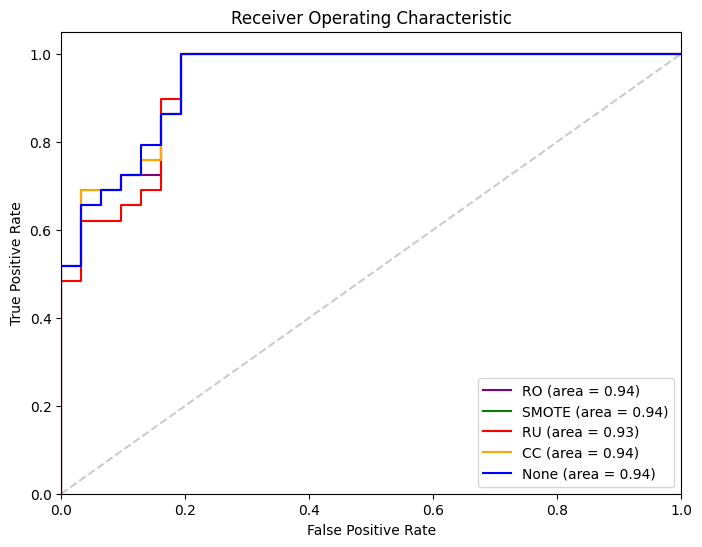

In [19]:
plt.figure(figsize=(8, 6))
colour_idx = 0 
colours = ['purple', 'green', 'red','orange','blue']

for name, (best_band,estimator, filter_b_a, best_W) in freqBandEstimators.items():
    probs = cross_val_predict(estimator, testData_motionIntent.iloc[:,:nCols-1], testData_motionIntent.iloc[:,nCols-1], cv=5, method="predict_proba")
    probs = probs[:, 1]  # use the probability of the positive class
    true_labels = testData_motionIntent.iloc[:,nCols-1]

    # Calculate ROC curve and AUC score
    fpr, tpr, thresholds = roc_curve(true_labels, probs)
    auc_score = auc(fpr, tpr)

    # Plot ROC curve for current model
    plt.plot(fpr, tpr, color=colours[colour_idx], label= name + ' (area = %0.2f)' % auc_score)
    colour_idx += 1

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print(f"{name} resampler optimal threshold : {optimal_threshold}")

plt.plot([0, 1], [0, 1], 'k--',alpha=0.2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Ultimately, I think the choice of going with neither oversampling nor undersampling results in a more accurate assesment of generalizing
ability. Given the fact that the continuous EEG signals that will be fed into the sliding window classifier will not be balanced with respect to class distribution, choosing a model based on it's ability to generalize on an even distribution of samples would be a mistake.

In [20]:
_, bestEstimator_freq_band, (best_b,best_a), W_freq_band = freqBandEstimators["None"]


### Person's Correlation Coefficient (PCC) + CSP

In [21]:
# #Plot distributions of channels against eachother
# # to find out if there is any sort of positive correlation
# # between channels

# import seaborn as sns
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# trialWin = np.arange(int(0*sRate),int(4*sRate))

# # #get mixed trial data from original
# trials_mixed = np.zeros(
#             (nChannels, len(eventOnsets[0]), len(trialWin)))


# for i, onset in enumerate(eventOnsets[0]):
#     trials_mixed[:,i,:] = eeg[:,onset+trialWin]

# # By augmenting the algorithm outlined in [ref: Electroencephalogram channel selection based on pearson correlation coefficient for motor imagery-brain-computer interface]
# # we are able to extract the most correlated channels in the given data prior to selecting features with the CSP algorithm.


# scaler = StandardScaler()

# # For each trial
# #We must standardize the values in each trial window for each channel (We use z-score normalization for this)
# _, nTrials, _ = trials_mixed.shape

# trialChannelCorrelations = []

# plotFirst = False #flag to check that heatmap of first trial is plotted

# for trial in range(nTrials):

#     zTrial = scaler.fit_transform(trials_mixed[:,trial,:])
#     corrMat = np.corrcoef(zTrial)

#     if not plotFirst:
#         plt.figure(figsize=(15, 16))
#         sns.heatmap(pd.DataFrame(corrMat,columns=channelNames,index=channelNames),cmap="RdYlGn",vmin=-1,vmax=1)
#         plotFirst = True

# #     # We must then calculate the correlation matrices for each trial and return the mean for each row, giving us a vector of mean values
# #     # which represents the average corellation values for a specific channel in relation to other channels.
#     channelCorrValues = {ch:corrMean for (ch,corrMean) in zip(channelNames,np.mean(corrMat,axis=1))}

# #     #Following the above referenced paper, we select the first 14 channels

#     channelCorrValues = dict(sorted(channelCorrValues.items(), key=lambda x:x[1], reverse=True)[:14])
#     trialChannelCorrelations.append(channelCorrValues)


In [22]:
# from collections import defaultdict

# channelOccurences = defaultdict(int)

# for dic in trialChannelCorrelations:
#     for ch, _ in dic.items():
#         channelOccurences[ch] += 1


# # This represent the most correlated channels ordered (descending) by the number of time they appear
# # in the most correlated channel list for each trial
# channelOccurences = dict(sorted(channelOccurences.items(), key=lambda x:x[1], reverse=True))

# selectedChannels = list(channelOccurences.keys())[:32]
# # #It can be seen that all selected channels are in and around the sensorimotor cortex

# selectedSet = set(selectedChannels)
# selectedIdxs = [idx for idx,ch in enumerate(channelNames) if ch in selectedSet]

# # #Plot heatmap of first trial
# plt.figure(figsize=(10, 8))
# sns.heatmap(pd.DataFrame(np.corrcoef(scaler.fit_transform(trials_mixed[selectedIdxs,0,:])),
#             columns=selectedChannels,
#             index=selectedChannels),
#             cmap="RdYlGn",
#             vmin=-1,
#             vmax=1)

# We can clearly see a positive correleation between some channels measuring along the same
# hemisphere on the motor strip e.g CFC1 and CCP1, and negative correleation between channels
# that are at approximately opposite hemishperes on the motor strip e.g C1 and C2
# While not all correlations fall in line (C1 and C3 having a negative correlation), some of the findings in
# this plot give credence to the theory of contralateral activation and supression for left and right hand motor imagery signals


In [23]:
# channelNums = dict()

# for i in range(2,nChannels+1):
#     selectedChannels = list(channelOccurences.keys())[:i]
#     # #It can be seen that all selected channels are in and around the sensorimotor cortex

#     selectedSet = set(selectedChannels)
#     selectedIdxs = [idx for idx,ch in enumerate(channelNames) if ch in selectedSet]

#     accVal = 0
#     bestAccVal = 0
#     bestEstimator_selected_channels = None
#     for model in ["Logistic Regression","LDA","SVC"]:
#         accVal, estimator, W =  testClassifier(dataB,0,4,0.7,model,b=best_b,a=best_a,selectedChannels=selectedIdxs)

#         if accVal > bestAccVal:
#             bestAccVal = accVal
#             bestEstimator_selected_channels = estimator

#     channelNums[i] = bestAccVal


In [24]:
#bestEstimator_selected_channels

In [25]:
# bestY = 0
# for x, y in channelNums.items():
#     bestY= max(bestY,y)
#     plt.bar(x,y)

# plt.xlabel("First N selected channels")
# plt.ylabel("Accuracy")
# plt.axhline(y=bestY, color='black', ls='--', lw=1.5, label=f"Best performance({bestY})")
# plt.legend(loc='lower right')


In [26]:
# probs = cross_val_predict(bestEstimator_selected_channels,testData_motionIntent.iloc[:,:nCols-1], testData_motionIntent.iloc[:,nCols-1],cv=5, method="predict_proba")
# probs = probs[:, 1]  # use the probability of the positive class
# true_labels = testData_motionIntent.iloc[:,nCols-1]

# # Calculate ROC curve and AUC score
# fpr, tpr, thresholds = roc_curve(true_labels, probs)
# auc_score = auc(fpr, tpr)

# # Plot ROC curve
# plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.show()


### Calibration of best classifier to predict probability outputs for all time samples

In [27]:
evalDataB = scipy.io.loadmat("BCICIV_1_mat/BCICIV_eval_ds1b.mat")

In [28]:
bestEstimator_freq_band

LogisticRegression(C=0.49417133613238334, class_weight='balanced',
                   solver='liblinear')

In [29]:
idlesStateClassifier
#SVC(C=1000, class_weight='balanced', gamma=0.1, probability=True)


SVC(C=1000, class_weight='balanced', gamma=0.1, probability=True)

In [30]:

from sklearn.calibration import CalibratedClassifierCV

bestEstimator_freq_band = CalibratedClassifierCV(bestEstimator_freq_band,cv="prefit")
bestEstimator_freq_band.fit(testData_motionIntent.iloc[:,:nCols-1], testData_motionIntent.iloc[:,nCols-1])

CalibratedClassifierCV(cv='prefit',
                       estimator=LogisticRegression(C=0.49417133613238334,
                                                    class_weight='balanced',
                                                    solver='liblinear'))

In [31]:
probabilities = startRunningClassifier(evalDataB,bestEstimator_freq_band,idlesStateClassifier,motionIntentComp, idleStateComp,W_freq_band,W_idle_motionIntent,trialWinStart=0,trialWinEnd=4,b=best_b,a=best_a)


In [34]:
import csv

with open("output_subject_b_100Hz.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(probabilities)


In [33]:
bestEstimator_freq_band.classes_

array([-1,  1])